In [1]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
from pathlib import Path
import numpy as np
import torch
from torch.backends import cudnn

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Configuration

In [3]:
import torch.utils.model_zoo

MOPED_PATH = Path('')
LINEMOD_PATH = Path('/ssd_scratch/cvit/amoghtiwari/latentfusion/data/lm_format')
CHECKPOINT = Path('/ssd_scratch/cvit/amoghtiwari/latentfusion/checkpoints/latentfusion-release.pth')
num_input_views = 8

In [4]:
import sys
sys.path.insert(0,'../')

##########
checkpoint = CHECKPOINT
############

In [5]:
from latentfusion.recon.inference import LatentFusionModel

model = LatentFusionModel.from_checkpoint(checkpoint, device)

2022-07-07 10:24.17 [warning  ] could not import PCL           [latentfusion.pointcloud] 
2022-07-07 10:24.21 [info     ] loaded model                   [latentfusion.recon.inference] epoch=200 name=shapenet,no_mask_morph,fixed_eqlr,256,mask,depth,in_mask,mask_noise_p=0.25,sm=nearest,fuser=gru-branched_20200509_10h19m10s-branched_20200509_10h42m53s-branched_20200509_10h46m53s-branched_20200509_10h48m49s


In [6]:
from latentfusion.recon.inference import Observation
from latentfusion.pose import bop
from latentfusion.datasets.bop_new import BOPDataset
from latentfusion.datasets.realsense import RealsenseDataset
import latentfusion.visualization as viz
from latentfusion.augment import gan_denormalize
from latentfusion import meshutils
from latentfusion import augment

Adding Anaconda lib path:/home/amoghtiwari/miniconda3/envs/latentfusion/lib/


## Load Dataset

### LINEMOD

Uncomment this and comment out the MOPED cell to use LINEMOD.

In [7]:
object_id = 201
frame = 0
input_scene_path = LINEMOD_PATH / f'train/{object_id:06d}'
target_scene_path = LINEMOD_PATH / f'test/{object_id:06d}'

input_dataset = BOPDataset(LINEMOD_PATH, input_scene_path, object_id=object_id, object_scale=None)
print('object_scale', input_dataset.object_scale)
target_dataset = BOPDataset(LINEMOD_PATH, target_scene_path, object_id=object_id, object_scale=None)
object_scale_to_meters = 1.0 / (1000.0 * target_dataset.object_scale)
pointcloud = input_dataset.load_pointcloud()

object_scale 0.0014823647857343534


### MOPED

In [8]:
# object_id = 'toy_plane'
# frame = 100

# input_scene_dir = MOPED_PATH / object_id / 'reference'
# target_scene_dir = MOPED_PATH / object_id / 'evaluation'

# pointcloud_path = input_scene_dir / 'integrated_registered_processed.obj'
# obj = meshutils.Object3D(pointcloud_path)
# pointcloud = torch.tensor(obj.vertices, dtype=torch.float32)
# diameter = obj.bounding_diameter
# object_scale = 1.0 / diameter
# object_scale_to_meters = 1.0 / object_scale

# input_paths = [x for x in input_scene_dir.iterdir() if x.is_dir()]
# input_dataset = RealsenseDataset(input_paths,
#                                  image_scale=1.0,
#                                  object_scale=object_scale,
#                                  odometry_type='open3d')
# target_paths = sorted([x for x in target_scene_dir.iterdir() if x.is_dir()])
# target_dataset = RealsenseDataset(target_paths,
#                                   image_scale=1.0,
#                                   object_scale=object_scale,
#                                   odometry_type='open3d',
#                                   use_registration=True)

### Process Dataset into Observations

Here we load the data into the `Observation` class.

#### Without Preprocessing and Denormalize

In [9]:
# input_obs = Observation.from_dataset(input_dataset, inds=input_dataset.sample_evenly(num_input_views))

# datum = next(iter(input_dataset))
# img = datum['color']
# depth_img = datum['depth']
# mask_img = datum['mask']


# plt.figure(figsize=(20, 10))
# plt.subplot(131)
# viz.show_batch(input_obs.color, nrow=4)
# plt.subplot(132)
# viz.show_batch(input_obs.depth, nrow=4)
# plt.subplot(133)
# viz.show_batch(input_obs.mask, nrow=4)

In [10]:
# datum = next(iter(input_dataset))
# img = datum['color']
# depth_img = datum['depth']
# mask_img = datum['mask']


# plt.figure(figsize=(20, 10))
# plt.subplot(131)
# viz.show_batch(img, nrow=4)
# plt.subplot(132)
# viz.show_batch(datum['depth'], nrow=4)
# plt.subplot(133)
# plt.imshow(datum['mask'], cmap='gray')

##### Mask Overlay

In [11]:
# plt.imshow(img.permute(1,2,0)) # I would add interpolation='none'
# # plt.show()
# plt.imshow(mask_img, cmap='gray', alpha=0.5) # interpolation='none'
# plt.show()

#### COMMENT: Checked till here. Everything is fine. Preprocessing step is causing problems

In [12]:
# input_obs_pp.mask.shape

In [13]:
input_dataset.sample_evenly(num_input_views)

tensor([ 0, 40, 65, 21, 80, 52, 14, 32])

Extrinsic pre decompose
 tensor([[[ 9.9987e-01,  1.6256e-02, -3.7082e-04,  1.9590e-01],
         [-1.5927e-02,  9.7454e-01, -2.2364e-01, -1.0665e+00],
         [-3.2741e-03,  2.2362e-01,  9.7467e-01,  1.0279e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-9.0290e-01,  1.3783e-01, -4.0716e-01, -4.9836e-01],
         [-2.4106e-01,  6.2189e-01,  7.4508e-01, -1.4939e+00],
         [ 3.5590e-01,  7.7088e-01, -5.2827e-01,  1.5245e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-4.7413e-01, -3.8281e-01,  7.9288e-01, -5.8209e-02],
         [ 4.5839e-01,  6.6154e-01,  5.9350e-01, -1.2838e+00],
         [-7.5172e-01,  6.4484e-01, -1.3818e-01,  1.2249e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 2.2231e-01,  3.1633e-01, -9.2223e-01,  1.2030e+00],
         [-5.4970e-01,  8.2189e-01,  1.4941e-01, -1.6284e+00],
         [ 8.0524e-01,  4.7373e-01,  3.5660e-01,  1.3801e+01],
         [ 0.0000e+00,  

         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])
translation post decompose
 tensor([[[ 1.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  1.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  1.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.4984],
         [ 0.0000,  1.0000,  0.0000, -1.4939],
         [ 0.0000,  0.0000,  1.0000, 15.2454],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.0582],
         [ 0.0000,  1.0000,  0.0000, -1.2838],
         [ 0.0000,  0.0000,  1.0000, 12.2486],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000,  1.2030],
         [ 0.0000,  1.0000,  0.0000, -1.6284],
         [ 0.0000,  0.0000,  1.0000, 13.8010],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -1.0414],
         [ 0.0000,  1.0000,  0.0000, -0.7910],
         [ 0.0000,  0.0000,  1.0000, 10.5521],
      

         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
tranlation matrix playgroud
 tensor([[ 0.1959, -1.0665, 10.2785],
        [-0.4984, -1.4939, 15.2454],
        [-0.0582, -1.2838, 12.2486],
        [ 1.2030, -1.6284, 13.8010],
        [-1.0414, -0.7910, 10.5521],
        [ 0.1728, -0.2067, 13.2825],
        [ 0.7238, -2.0785, 15.3788],
        [-2.0054, -2.3418, 15.7896]])
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[-0.4984],
         [-1.4939],
         [15.2454]],

        [[-0.0582],
         [-1.2838],
         [12.2486]],

        [[ 1.2030],
         [-1.6284],
         [13.8010]],

        [[-1.0414],
         [-0.7910],
         [10.5521]],

        [[ 0.1728],
         [-0.2067],
         [13.2825]],

        [[ 0.7238],
         [-2.0785],
         [15.3788]],

        [[-2.0054],
         [-2.3418],
         [15.7896]]])
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
     

../latentfusion/modules/geometry.py:361: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1654413022026/work/aten/src/ATen/native/TensorShape.cpp:2890.)
  grids = bboxes_to_grid(boxes, in_size, out_size)


Intrinsic matrix tensor([[[1.1908e+03, 0.0000e+00, 9.6850e+02, 0.0000e+00],
         [0.0000e+00, 1.1903e+03, 5.4050e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]],

        [[1.5635e+03, 0.0000e+00, 9.7900e+02, 0.0000e+00],
         [0.0000e+00, 1.5629e+03, 5.4200e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]],

        [[1.5332e+03, 0.0000e+00, 9.9950e+02, 0.0000e+00],
         [0.0000e+00, 1.5324e+03, 5.0700e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]],

        [[1.3527e+03, 0.0000e+00, 9.9950e+02, 0.0000e+00],
         [0.0000e+00, 1.3517e+03, 5.3650e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]],

        [[1.5597e+03, 0.0000e+00, 9.5200e+02, 0.0000e+00],
         [0.0000e+00, 1.5590e+03, 5.3500e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]],

        [[1.8058e+03, 0.0000e+00, 9.9950e+02, 0.0000e+00],
         [0.0000e+00, 1.8044e

         [ 0.0000,  0.0000,  0.0000,  0.0000]]])
tensor([[[ 1.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  1.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  1.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.4984],
         [ 0.0000,  1.0000,  0.0000, -1.4939],
         [ 0.0000,  0.0000,  1.0000, 15.2454],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.0582],
         [ 0.0000,  1.0000,  0.0000, -1.2838],
         [ 0.0000,  0.0000,  1.0000, 12.2486],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000,  1.2030],
         [ 0.0000,  1.0000,  0.0000, -1.6284],
         [ 0.0000,  0.0000,  1.0000, 13.8010],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -1.0414],
         [ 0.0000,  1.0000,  0.0000, -0.7910],
         [ 0.0000,  0.0000,  1.0000, 10.5521],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

 

         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
tranlation matrix playgroud
 tensor([[ 0.1959, -1.0665, 10.2785],
        [-0.4984, -1.4939, 15.2454],
        [-0.0582, -1.2838, 12.2486],
        [ 1.2030, -1.6284, 13.8010],
        [-1.0414, -0.7910, 10.5521],
        [ 0.1728, -0.2067, 13.2825],
        [ 0.7238, -2.0785, 15.3788],
        [-2.0054, -2.3418, 15.7896]])
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[-0.4984],
         [-1.4939],
         [15.2454]],

        [[-0.0582],
         [-1.2838],
         [12.2486]],

        [[ 1.2030],
         [-1.6284],
         [13.8010]],

        [[-1.0414],
         [-0.7910],
         [10.5521]],

        [[ 0.1728],
         [-0.2067],
         [13.2825]],

        [[ 0.7238],
         [-2.0785],
         [15.3788]],

        [[-2.0054],
         [-2.3418],
         [15.7896]]])
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
     

         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
tranlation matrix playgroud
 tensor([[ 0.1959, -1.0665, 10.2785],
        [-0.4984, -1.4939, 15.2454],
        [-0.0582, -1.2838, 12.2486],
        [ 1.2030, -1.6284, 13.8010],
        [-1.0414, -0.7910, 10.5521],
        [ 0.1728, -0.2067, 13.2825],
        [ 0.7238, -2.0785, 15.3788],
        [-2.0054, -2.3418, 15.7896]])
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[-0.4984],
         [-1.4939],
         [15.2454]],

        [[-0.0582],
         [-1.2838],
         [12.2486]],

        [[ 1.2030],
         [-1.6284],
         [13.8010]],

        [[-1.0414],
         [-0.7910],
         [10.5521]],

        [[ 0.1728],
         [-0.2067],
         [13.2825]],

        [[ 0.7238],
         [-2.0785],
         [15.3788]],

        [[-2.0054],
         [-2.3418],
         [15.7896]]])
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
     

         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
translation matrix tensor([[[ 1.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  1.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  1.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.4984],
         [ 0.0000,  1.0000,  0.0000, -1.4939],
         [ 0.0000,  0.0000,  1.0000, 15.2454],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.0582],
         [ 0.0000,  1.0000,  0.0000, -1.2838],
         [ 0.0000,  0.0000,  1.0000, 12.2486],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000,  1.2030],
         [ 0.0000,  1.0000,  0.0000, -1.6284],
         [ 0.0000,  0.0000,  1.0000, 13.8010],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -1.0414],
         [ 0.0000,  1.0000,  0.0000, -0.7910],
         [ 0.0000,  0.0000,  1.0000, 10.5521],
         [ 0.0000,  0.0000,  0.

         [ 0.0000,  0.0000,  0.0000,  0.0000]]])
tensor([[[ 1.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  1.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  1.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.4984],
         [ 0.0000,  1.0000,  0.0000, -1.4939],
         [ 0.0000,  0.0000,  1.0000, 15.2454],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.0582],
         [ 0.0000,  1.0000,  0.0000, -1.2838],
         [ 0.0000,  0.0000,  1.0000, 12.2486],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000,  1.2030],
         [ 0.0000,  1.0000,  0.0000, -1.6284],
         [ 0.0000,  0.0000,  1.0000, 13.8010],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -1.0414],
         [ 0.0000,  1.0000,  0.0000, -0.7910],
         [ 0.0000,  0.0000,  1.0000, 10.5521],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

 

         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]]])
tranlation matrix playgroud
 tensor([[ 0.1959, -1.0665, 10.2785],
        [-0.4984, -1.4939, 15.2454],
        [-0.0582, -1.2838, 12.2486],
        [ 1.2030, -1.6284, 13.8010],
        [-1.0414, -0.7910, 10.5521],
        [ 0.1728, -0.2067, 13.2825],
        [ 0.7238, -2.0785, 15.3788],
        [-2.0054, -2.3418, 15.7896]])
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[-0.4984],
         [-1.4939],
         [15.2454]],

        [[-0.0582],
         [-1.2838],
         [12.2486]],

        [[ 1.2030],
         [-1.6284],
         [13.8010]],

        [[-1.0414],
         [-0.7910],
         [10.5521]],

        [[ 0.1728],
         [-0.2067],
         [13.2825]],

        [[ 0.7238],
         [-2.0785],
         [15.3788]],

        [[-2.0054],
         [-2.3418],
         [15.7896]]])
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.

         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
From observation.py zoom function end; mask torch.Size([8, 1, 256, 256])
From observation.py zoom function end; color torch.Size([8, 3, 256, 256])
From observation.py zoom function end; depth torch.Size([8, 1, 256, 256])
From observation.py prepare function; mask torch.Size([8, 1, 256, 256])
From observation.py prepare function; color torch.Size([8, 3, 256, 256])
From observation.py prepare function; depth torch.Size([8, 1, 256, 256])
tranlation matrix playgroud
 tensor([[ 0.1959, -1.0665, 10.2785],
        [-0.4984, -1.4939, 15.2454],
        [-0.0582, -1.2838, 12.2486],
        [ 1.2030, -1.6284, 13.8010],
        [-1.0414, -0.7910, 10.5521],
        [ 0.1728, -0.2067, 13.2825],
        [ 0.7238, -2.0785, 15.3788],
        [-2.0054, -2.3418, 15.7896]])
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[-0.4984],
         [-1.4939],
         [15.2454]],

        [[-0.0582],
         [-1

         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
From observation.py zoom function start; mask torch.Size([1, 1, 480, 640])
From observation.py zoom function start; color torch.Size([1, 3, 480, 640])
From observation.py zoom function start; depth torch.Size([1, 1, 480, 640])
Intrinsic matrix tensor([[[1.1908e+03, 0.0000e+00, 9.6850e+02, 0.0000e+00],
         [0.0000e+00, 1.1903e+03, 5.4050e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]]])
tranlation matrix playgroud
 tensor([[ 0.1959, -1.0665, 10.2785]])
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]]])
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]])
tensor([[[ 1.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  1.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  1.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  

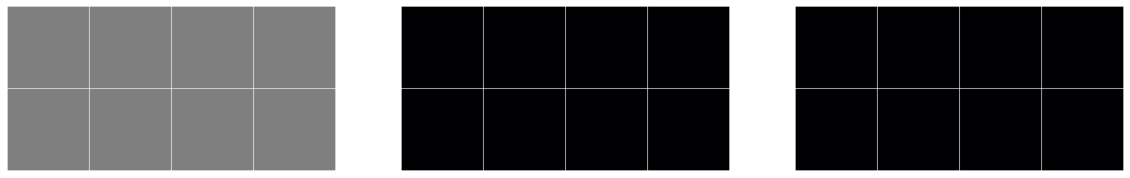

In [14]:
input_obs = Observation.from_dataset(input_dataset, inds=input_dataset.sample_evenly(num_input_views))
input_obs_gt = Observation.from_dataset(input_dataset, inds=input_dataset.sample_evenly(num_input_views))
target_obs = Observation.from_dataset(target_dataset, inds=list(range(len(target_dataset)))[frame:frame+1])
print("From notebeook; input_obs.color.shape", input_obs.color.shape)
print("From notebeook; input_obs.mask.shape", input_obs.mask.shape)
print("From notebeook; input_obs.depth.shape", input_obs.depth.shape)

input_obs_pp = model.preprocess_observation(input_obs)
input_obs_pp_gt = model.preprocess_observation(input_obs)
target_obs_pp = model.preprocess_observation(target_obs)

print("From notebeook; input_obs_pp.color.shape", input_obs_pp.color.shape)
print("From notebeook; input_obs_pp.mask.shape", input_obs_pp.mask.shape)
print("From notebeook; input_obs_pp.depth.shape", input_obs_pp.depth.shape)

plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(gan_denormalize(input_obs_pp.color), nrow=4)
plt.subplot(132)
viz.show_batch(viz.colorize_depth(input_obs_pp.depth), nrow=4)
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(input_obs_pp.mask), nrow=4)

In [15]:
input_obs_pp.color[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [16]:
np.where(input_obs_pp.color[0] != 0)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [17]:
input_obs_pp.color[0].dtype

torch.float32

In [18]:
torch.sum(input_obs_pp.color[0])

tensor(0.)

In [19]:
input_obs.color.shape

torch.Size([8, 3, 480, 640])

In [20]:
input_obs_pp.color.shape

torch.Size([8, 3, 256, 256])

In [21]:
# break

## Build Latent Object

This builds the 'latent object', referred to as `z_obj` in this code.

hi ho la torch.Size([8, 512, 8, 8])
tranlation matrix playgroud
 tensor([[ 0.1959, -1.0665, 10.2785],
        [-0.4984, -1.4939, 15.2454],
        [-0.0582, -1.2838, 12.2486],
        [ 1.2030, -1.6284, 13.8010],
        [-1.0414, -0.7910, 10.5521],
        [ 0.1728, -0.2067, 13.2825],
        [ 0.7238, -2.0785, 15.3788],
        [-2.0054, -2.3418, 15.7896]], device='cuda:0')
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[-0.4984],
         [-1.4939],
         [15.2454]],

        [[-0.0582],
         [-1.2838],
         [12.2486]],

        [[ 1.2030],
         [-1.6284],
         [13.8010]],

        [[-1.0414],
         [-0.7910],
         [10.5521]],

        [[ 0.1728],
         [-0.2067],
         [13.2825]],

        [[ 0.7238],
         [-2.0785],
         [15.3788]],

        [[-2.0054],
         [-2.3418],
         [15.7896]]], device='cuda:0')
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.

        [-2.0054, -2.3418, 15.7896]], device='cuda:0')
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[-0.4984],
         [-1.4939],
         [15.2454]],

        [[-0.0582],
         [-1.2838],
         [12.2486]],

        [[ 1.2030],
         [-1.6284],
         [13.8010]],

        [[-1.0414],
         [-0.7910],
         [10.5521]],

        [[ 0.1728],
         [-0.2067],
         [13.2825]],

        [[ 0.7238],
         [-2.0785],
         [15.3788]],

        [[-2.0054],
         [-2.3418],
         [15.7896]]], device='cuda:0')
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000, -0.4984],
         [ 0.0000,  0.0000,  0.0000, -1.4939],
         [ 0.0000,  0.0000,  0.0000, 15.2454],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.

         [15.7896]]], device='cuda:0')
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000, -0.4984],
         [ 0.0000,  0.0000,  0.0000, -1.4939],
         [ 0.0000,  0.0000,  0.0000, 15.2454],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000, -0.0582],
         [ 0.0000,  0.0000,  0.0000, -1.2838],
         [ 0.0000,  0.0000,  0.0000, 12.2486],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  1.2030],
         [ 0.0000,  0.0000,  0.0000, -1.6284],
         [ 0.0000,  0.0000,  0.0000, 13.8010],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000, -1.0414],
         [ 0.0000,  0.0000,  0.0000, -0.7910],
         [ 0.0000,  0.0000,  0.0000, 10.5521],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 

         [ 0.0000,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
tensor([[[ 1.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  1.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  1.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.4984],
         [ 0.0000,  1.0000,  0.0000, -1.4939],
         [ 0.0000,  0.0000,  1.0000, 15.2454],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.0582],
         [ 0.0000,  1.0000,  0.0000, -1.2838],
         [ 0.0000,  0.0000,  1.0000, 12.2486],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000,  1.2030],
         [ 0.0000,  1.0000,  0.0000, -1.6284],
         [ 0.0000,  0.0000,  1.0000, 13.8010],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -1.0414],
         [ 0.0000,  1.0000,  0.0000, -0.7910],
         [ 0.0000,  0.0000,  1.0000, 10.5521],
         [ 0.0000,  0.0000,  0.00

         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')
tranlation matrix playgroud
 tensor([[ 0.1959, -1.0665, 10.2785],
        [-0.4984, -1.4939, 15.2454],
        [-0.0582, -1.2838, 12.2486],
        [ 1.2030, -1.6284, 13.8010],
        [-1.0414, -0.7910, 10.5521],
        [ 0.1728, -0.2067, 13.2825],
        [ 0.7238, -2.0785, 15.3788],
        [-2.0054, -2.3418, 15.7896]], device='cuda:0')
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[-0.4984],
         [-1.4939],
         [15.2454]],

        [[-0.0582],
         [-1.2838],
         [12.2486]],

        [[ 1.2030],
         [-1.6284],
         [13.8010]],

        [[-1.0414],
         [-0.7910],
         [10.5521]],

        [[ 0.1728],
         [-0.2067],
         [13.2825]],

        [[ 0.7238],
         [-2.0785],
         [15.3788]],

        [[-2.0054],
         [-2.3418],
         [15.7896]]], device='cuda:0')
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
 

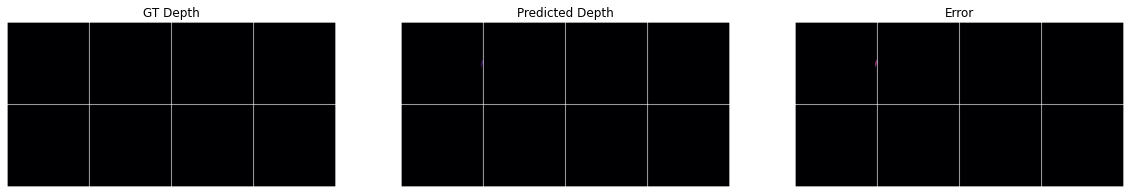

In [22]:
from latentfusion import three
import math

with torch.no_grad():
    z_obj = model.build_latent_object(input_obs_pp)

    # Visualize prediction.
    camera = input_obs_pp.camera.clone()
    y, z = model.render_latent_object(z_obj, camera.to(device))

recon_error = (y['depth'].detach().cpu() - input_obs_pp_gt.depth).abs()
print('recon_error', recon_error.mean().item())
    
plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(viz.colorize_depth(input_obs_pp.depth), nrow=4, title='GT Depth')
plt.subplot(132)
viz.show_batch(viz.colorize_depth(y['depth'].detach().cpu()), nrow=4, title='Predicted Depth')
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(recon_error), nrow=4, title='Error')


### Visualize some novel views

This visualizes the object from novel views.

Intrinsic matrix tensor([[[1.1908e+03, 0.0000e+00, 9.6850e+02, 0.0000e+00],
         [0.0000e+00, 1.1903e+03, 5.4050e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]]])
tranlation matrix playgroud
 tensor([[ 0.1959, -1.0665, 10.2785]])
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]]])
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]])
tensor([[[ 1.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  1.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  1.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
translation matrix tensor([[[ 1.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  1.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  1.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
tranlation matrix playgroud
 tensor([[ 0.1959, -1.0665, 

         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
tranlation matrix playgroud
 tensor([[ 0.1959, -1.0665, 10.2785],
        [-0.4984, -1.4939, 15.2454],
        [-0.0582, -1.2838, 12.2486],
        [ 1.2030, -1.6284, 13.8010],
        [-1.0414, -0.7910, 10.5521],
        [ 0.1728, -0.2067, 13.2825],
        [ 0.7238, -2.0785, 15.3788],
        [-2.0054, -2.3418, 15.7896]])
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[-0.4984],
         [-1.4939],
         [15.2454]],

        [[-0.0582],
         [-1.2838],
         [12.2486]],

        [[ 1.2030],
         [-1.6284],
         [13.8010]],

        [[-1.0414],
         [-0.7910],
         [10.5521]],

        [[ 0.1728],
         [-0.2067],
         [13.2825]],

        [[ 0.7238],
         [-2.0785],
         [15.3788]],

        [[-2.0054],
         [-2.3418],
         [15.7896]]])
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
     

         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
translation matrix tensor([[[ 1.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  1.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  1.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.4984],
         [ 0.0000,  1.0000,  0.0000, -1.4939],
         [ 0.0000,  0.0000,  1.0000, 15.2454],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.0582],
         [ 0.0000,  1.0000,  0.0000, -1.2838],
         [ 0.0000,  0.0000,  1.0000, 12.2486],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000,  1.2030],
         [ 0.0000,  1.0000,  0.0000, -1.6284],
         [ 0.0000,  0.0000,  1.0000, 13.8010],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -1.0414],
         [ 0.0000,  1.0000,  0.0000, -0.7910],
         [ 0.0000,  0.0000,  1.0000, 10.5521],
         [ 0.0000,  0.0000,  0.

         [ 0.0000,  0.0000,  0.0000,  0.0000]]])
tensor([[[ 1.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  1.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  1.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.4984],
         [ 0.0000,  1.0000,  0.0000, -1.4939],
         [ 0.0000,  0.0000,  1.0000, 15.2454],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.0582],
         [ 0.0000,  1.0000,  0.0000, -1.2838],
         [ 0.0000,  0.0000,  1.0000, 12.2486],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000,  1.2030],
         [ 0.0000,  1.0000,  0.0000, -1.6284],
         [ 0.0000,  0.0000,  1.0000, 13.8010],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -1.0414],
         [ 0.0000,  1.0000,  0.0000, -0.7910],
         [ 0.0000,  0.0000,  1.0000, 10.5521],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

 

         [15.7896]]])
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000, -0.4984],
         [ 0.0000,  0.0000,  0.0000, -1.4939],
         [ 0.0000,  0.0000,  0.0000, 15.2454],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000, -0.0582],
         [ 0.0000,  0.0000,  0.0000, -1.2838],
         [ 0.0000,  0.0000,  0.0000, 12.2486],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  1.2030],
         [ 0.0000,  0.0000,  0.0000, -1.6284],
         [ 0.0000,  0.0000,  0.0000, 13.8010],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000, -1.0414],
         [ 0.0000,  0.0000,  0.0000, -0.7910],
         [ 0.0000,  0.0000,  0.0000, 10.5521],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000, 

         [ 0.0000,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
tensor([[[ 1.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  1.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  1.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.4984],
         [ 0.0000,  1.0000,  0.0000, -1.4939],
         [ 0.0000,  0.0000,  1.0000, 15.2454],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.0582],
         [ 0.0000,  1.0000,  0.0000, -1.2838],
         [ 0.0000,  0.0000,  1.0000, 12.2486],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000,  1.2030],
         [ 0.0000,  1.0000,  0.0000, -1.6284],
         [ 0.0000,  0.0000,  1.0000, 13.8010],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -1.0414],
         [ 0.0000,  1.0000,  0.0000, -0.7910],
         [ 0.0000,  0.0000,  1.0000, 10.5521],
         [ 0.0000,  0.0000,  0.00

         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')
hi ho la torch.Size([16, 512, 8, 8])
tranlation matrix playgroud
 tensor([[ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785],
        [ 0.1959, -1.0665, 10.2785]], device='cuda:0')
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
  

        [ 0.1959, -1.0665, 10.2785]], device='cuda:0')
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[ 0.1959],
         [-1.0665],
       

         [ 0.0000,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
tensor([[[ 1.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  1.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  1.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.4984],
         [ 0.0000,  1.0000,  0.0000, -1.4939],
         [ 0.0000,  0.0000,  1.0000, 15.2454],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -0.0582],
         [ 0.0000,  1.0000,  0.0000, -1.2838],
         [ 0.0000,  0.0000,  1.0000, 12.2486],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000,  1.2030],
         [ 0.0000,  1.0000,  0.0000, -1.6284],
         [ 0.0000,  0.0000,  1.0000, 13.8010],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000,  0.0000,  0.0000, -1.0414],
         [ 0.0000,  1.0000,  0.0000, -0.7910],
         [ 0.0000,  0.0000,  1.0000, 10.5521],
         [ 0.0000,  0.0000,  0.00

         [10.2785]]], device='cuda:0')
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]

         [10.2785]]], device='cuda:0')
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]

         [10.2785]]], device='cuda:0')
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.1959],
         [ 0.0000,  0.0000,  0.0000, -1.0665],
         [ 0.0000,  0.0000,  0.0000, 10.2785],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]

         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')
tranlation matrix playgroud
 tensor([[ 0.1959, -1.0665, 10.2785],
        [-0.4984, -1.4939, 15.2454],
        [-0.0582, -1.2838, 12.2486],
        [ 1.2030, -1.6284, 13.8010],
        [-1.0414, -0.7910, 10.5521],
        [ 0.1728, -0.2067, 13.2825],
        [ 0.7238, -2.0785, 15.3788],
        [-2.0054, -2.3418, 15.7896]], device='cuda:0')
tranlation matrixplaygroud  
 tensor([[[ 0.1959],
         [-1.0665],
         [10.2785]],

        [[-0.4984],
         [-1.4939],
         [15.2454]],

        [[-0.0582],
         [-1.2838],
         [12.2486]],

        [[ 1.2030],
         [-1.6284],
         [13.8010]],

        [[-1.0414],
         [-0.7910],
         [10.5521]],

        [[ 0.1728],
         [-0.2067],
         [13.2825]],

        [[ 0.7238],
         [-2.0785],
         [15.3788]],

        [[-2.0054],
         [-2.3418],
         [15.7896]]], device='cuda:0')
tensor([[[ 0.0000,  0.0000,  0.0000,  0.1959],
 

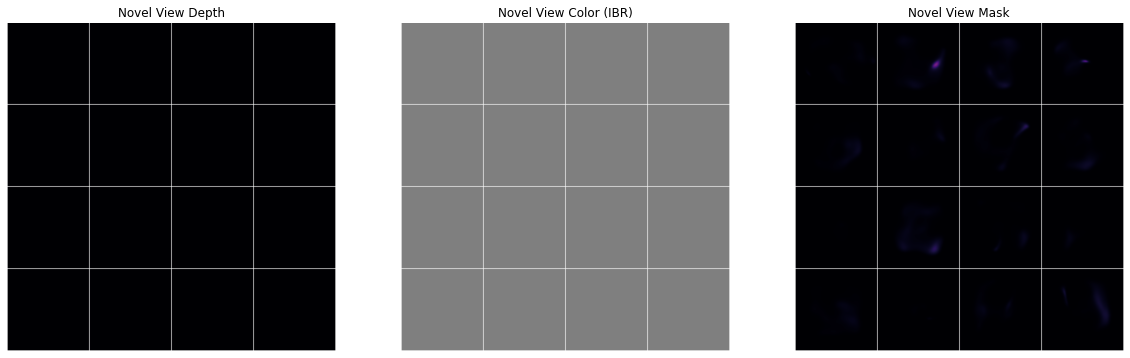

In [23]:
from latentfusion.three.orientation import evenly_distributed_quats
num_novel = 16
camera_ref = input_obs.camera[0]
camera_ref = camera_ref.zoom(None, model.camera_dist, model.input_size)
quats = evenly_distributed_quats(num_novel, upright=True).to(device)
camera_test = camera_ref.clone().repeat(num_novel)
camera_test.quaternion = quats

with torch.no_grad():
    y, _ = model.render_ibr_basic(z_obj, input_obs, camera_test.clone().to(device), apply_mask=True)

plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(viz.colorize_depth(y['depth']), nrow=4, title='Novel View Depth')
plt.subplot(132)
viz.show_batch(gan_denormalize(y['color'].cpu()), nrow=4, title='Novel View Color (IBR)')
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(y['mask']), nrow=4, title='Novel View Mask')

## Coarse Pose Estimation

In [24]:
import latentfusion.pose.estimation as pe
from functools import partial

estimator = pe.load_from_config('../configs/cross_entropy_latent.toml', model, return_camera_history=False, verbose=False)

coarse_camera = estimator.estimate(z_obj, target_obs[0])
camera_zoom = coarse_camera.zoom(None, model.camera_dist, model.input_size)

# Visualize prediction.
pred_y, pred_z = model.render_latent_object(z_obj, camera_zoom.to(device))
pred_mask = pred_y['mask'].squeeze(0)
pred_depth = pred_y['depth'].squeeze(0)
pred_depth = camera_zoom.denormalize_depth(pred_depth) * pred_mask
pred_depth, _ = camera_zoom.uncrop(pred_depth)
pred_mask, _ = camera_zoom.uncrop(pred_mask)
pred_depth = pred_depth.cpu()
pred_mask = pred_mask.cpu()

plt.figure(1, figsize=(10, 10))
plt.subplot(131)
viz.show_batch(target_obs.color[0], nrow=2)
plt.subplot(132)
viz.show_batch(viz.colorize_tensor(target_obs[0].depth.cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=2)
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(target_obs.prepare()[0].mask.cpu()), nrow=2)

plt.figure(2, figsize=(20, 10))
plt.subplot(121)
viz.show_batch(viz.colorize_tensor(pred_depth.detach().cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=4, title="Estimated Depth")

plt.subplot(122)
viz.show_batch(viz.colorize_tensor((target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()), nrow=4, title="Estimated Depth L1 Error")

2022-07-07 10:24.29 [info     ] loading pose estimator from config [latentfusion.pose.estimation] init_hemisphere=False init_upright=False learning_rate=0.3 loss_weights={'depth': 0.0, 'ov_depth': 0.0, 'iou': 0.0, 'mask': 0.0, 'latent': 1.0} num_elites=48 num_gmm_components=6 num_iters=30 num_samples=96 ranking_size=16 return_camera_history=False sample_flipped=True type=cross_entropy verbose=False


Extrinsic pre decompose
 tensor([[[  1.0000,   0.0000,   0.0000, -41.9451],
         [  0.0000,   1.0000,   0.0000, -22.4182],
         [  0.0000,   0.0000,   1.0000,  76.0251],
         [  0.0000,   0.0000,   0.0000,   1.0000]]])
rotation post decompose
 tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]])
translation post decompose
 tensor([[[  1.0000,   0.0000,   0.0000, -41.9451],
         [  0.0000,   1.0000,   0.0000, -22.4182],
         [  0.0000,   0.0000,   1.0000,  76.0251],
         [  0.0000,   0.0000,   0.0000,   1.0000]]])
Extrinsic pre decompose
 tensor([[[-9.9422e-01, -1.0629e-01,  1.5412e-02, -4.1945e+01],
         [-1.0526e-01,  9.9282e-01,  5.6848e-02, -2.2418e+01],
         [-2.1344e-02,  5.4897e-02, -9.9826e-01,  7.6025e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-2.1720e-01,  9.7402e-01, -6.4117e-02, -4.1945e+01],
         [ 9.7184e-01,  2.2193e-01,  7.9237e-02, -2.2418e+

ValueError: Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.

### Fine Pose Estimation

In [ ]:
from latentfusion import utils
from latentfusion.pose import utils as pose_utils
from latentfusion.modules.geometry import Camera

sgd_estimator = pe.load_from_config('../configs/adam_quick.toml', model, track_stats=True, return_camera_history=True, num_iters=100)

init_camera = coarse_camera.clone()
refined_camera, stat_history, camera_history = sgd_estimator.estimate(z_obj, target_obs[0], camera=init_camera)
camera_zoom = refined_camera.zoom(None, model.camera_dist, model.input_size)

# Visualize prediction.
pred_y, pred_z = model.render_latent_object(z_obj, camera_zoom.to(device))
pred_mask = pred_y['mask'].squeeze(0)
pred_depth = pred_y['depth'].squeeze(0)
pred_depth = camera_zoom.denormalize_depth(pred_depth) * (pred_y['mask'].squeeze(0) > 0.5)
pred_depth, _ = camera_zoom.uncrop(pred_depth)
pred_mask, _ = camera_zoom.uncrop(pred_mask)
depth_error = (target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()
pred_depth = pred_depth.cpu()
pred_mask = pred_mask.cpu()
depth_error = depth_error.cpu()


plt.figure(1, figsize=(10, 10))
plt.subplot(131)
viz.show_batch(target_obs.color[0], nrow=2)
plt.subplot(132)
viz.show_batch(viz.colorize_tensor(target_obs[0].depth, cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=2)
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(target_obs.prepare()[0].mask), nrow=2)

plt.figure(2, figsize=(20, 10))
plt.subplot(121)
viz.show_batch(viz.colorize_tensor(pred_depth.detach().cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=4, title="Estimated Depth")

plt.subplot(122)
viz.show_batch(viz.colorize_tensor((target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()), nrow=4, title="Estimated Depth L1 Error")

In [ ]:
from latentfusion.pose.metrics import camera_metrics
from latentfusion.pose.format import metrics_table_multiple


for j in range(1):
    print(metrics_table_multiple([
            camera_metrics(target_obs.camera, coarse_camera[j], pointcloud, object_scale_to_meters),
            camera_metrics(target_obs.camera, refined_camera[j], pointcloud, object_scale_to_meters),
    ], ['Coarse', 'Refined'], tablefmt='simple'))

### Plot pose refinement stats over time

In [ ]:
import math

viz.plot_grid(3, figsize=(30, 15), plots=[
    viz.Plot('Angular Error', [stat_history['angle_dist']/math.pi*180], 
             params={'ylabel': 'Error (deg)', 'xlabel': 'Iteration'}),
    viz.Plot('Translation Error', [stat_history['trans_dist']*object_scale_to_meters], 
             params={'ylabel': 'Error (m)', 'xlabel': 'Iteration'}),
    viz.Plot('Rank Loss', [stat_history['rank_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('Optim Loss', [stat_history['optim_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    
    viz.Plot('Depth Loss', [stat_history['depth_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('Overlap Depth Loss', [stat_history['ov_depth_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('Mask Loss', [stat_history['mask_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('IOU Loss', [stat_history['iou_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('<5 deg <5 cm', [(stat_history['trans_dist']*object_scale_to_meters < 0.05) & (stat_history['angle_dist']/math.pi*180 < 5)], 
             params={'ylabel': 'Success', 'xlabel': 'Iteration'}),
]);